# Тестирование планирования траектории с помощью полиномов пятого порядка

Полиномы 5-го порядка являются оптимальной траекторией из состояния $[x_1, \dot{x_1}, \ddot{x_1}]$ в состояние $[x_2, \dot{x_2}, \ddot{x_2}]$, минимизируя функционал стоимости:
$$
J = \int_{t_0}^{t_1}\dddot{x}^2(t)dt
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.lines as mlines


In [134]:
# Находит коэффициенты полинома 
# s1 - начальное состояние (x, dx/dt, d2x/dt^2) 
# s2 - конечное состояние  (x, dx/dt, d2x/dt^2)
# T  - время перехода
# Возвращает коэффициенты полинома
def quintic_solve(s1, s2, T):
    A = np.array([[   0,       0,       0,      0,    0, 1],
                  [   0,       0,       0,      0,    1, 0],
                  [   0,       0,       0,      1,    0, 0],
                  [   T**5,    T**4,    T**3,   T**2, T, 1],
                  [ 5*T**4,  4*T**3,  3*T**2, 2*T,    1, 0], 
                  [20*T**3, 12*T**2,  6*T,      1,    0, 0]])
    B = np.array([s1[0], s1[1], s1[2], s2[0], s2[1], s2[2]])
    return np.linalg.solve(A, B)

def calc_quintic(a, x):
    return a[0]*x**5 + a[1]*x**4 + a[2]*x**3 + a[3]*x**2 + a[4]*x + a[5]

def calc_dquintic(a, x):
    return 5*a[0]*x**4 + 4*a[1]*x**3 + 3*a[2]*x**2 + 2*a[3]*x + a[4]

def calc_ddquintic(a, x):
    return 20*a[0]*x**3 + 12*a[1]*x**2 + 6*a[2]*x + a[3]

def quintic_interpolate(a, linspace):
    x, dx, ddx = [], [], []
    
    for t in linspace:
        x.append(calc_quintic(a, t))
        dx.append(calc_dquintic(a, t))
        ddx.append(calc_ddquintic(a, t))
        
    return x, dx, ddx

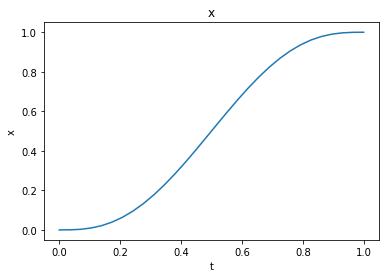

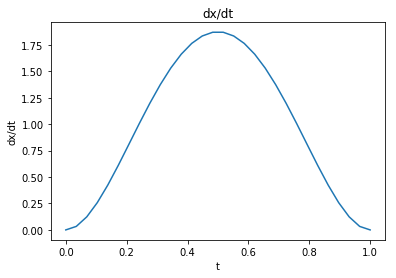

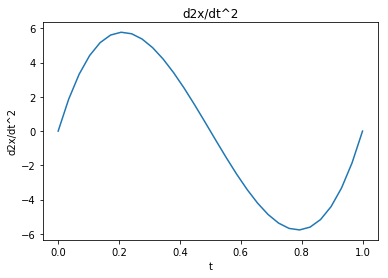

In [11]:
t = 1.0
coefs = quintic_solve((0, 0, 0), (1, 0, 0), t)
tt = np.linspace(0, t, 30)
x, dx, ddx = quintic_interpolate(coefs, tt)

plt.plot(tt, x)
plt.xlabel('t')
plt.ylabel('x')
plt.title('x')
plt.show()

plt.plot(tt, dx)
plt.xlabel('t')
plt.ylabel('dx/dt')
plt.title('dx/dt')
plt.show()

plt.plot(tt, ddx)
plt.xlabel('t')
plt.ylabel('d2x/dt^2')
plt.title('d2x/dt^2')
plt.show()

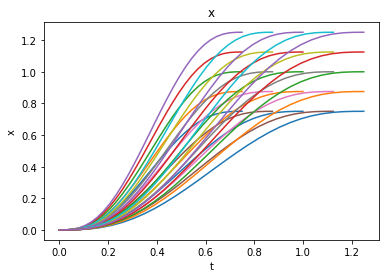

In [12]:
x_range = 0.5
t_range = 0.5
range_cnt = 5

x_variants = np.linspace(1 - x_range/2, 1 + x_range/2, range_cnt)
t_variants = np.linspace(1 - x_range/2, 1 + x_range/2, range_cnt)

variants = []

for t in t_variants:
    t_linspace = np.linspace(0, t, 30)
    for x in x_variants:
        coefs = quintic_solve([0, 0, 0], [x, 0, 0], t)
        x, _, _ = quintic_interpolate(coefs, t_linspace)
        variants.append((t_linspace, x))

for t, x in variants:
    plt.plot(t, x)
    
plt.xlabel('t')
plt.ylabel('x')
plt.title('x')
plt.show()

In [86]:
class FrenetFrame:
    """
    Represents the Frenet Frame
    
    Perform transformation world frame -> local frenet frame
    and local frenet frame -> world frame
    
    Notation:            
        tr  - tangent vector
        nr  - normal vector
        br  - binormal vector (for surface - up)
        Rwf - orientation of local frame with respect to parent frame           
        Rfw - orientation of world frame with respect to parent frame
        Pwf - position of the origin of the local with respect to parent frame
    
    Math:
        local->parent transformation:
            Qw = Pwf + Rwf*Qf
            Qa - position in parent frame
            Qb - position in local frame
    
    """
    def __init__(self, p1, p2):
        """
        Create Frenet Frame with two close points on discrete curve
        Else, p1p2 - tangent vector of the curve
        """
        # local frame axis in parent frame
        self.br = [0, 0, 1]
        self.tr = p2-p1
        self.tr = self.tr/np.linalg.norm(self.tr)
        self.nr = np.cross(self.br, self.tr)
        
        # local frame orientation with respect to parent frame
        self.Rwf = np.identity(3)
        self.Rwf[:,0]=self.tr
        self.Rwf[:,1]=self.nr
        self.Rwf[:,2]=self.br
        
        # parent frame orientation with respect to local frame
        self.Rfw = np.transpose(self.Rwf)
        
        # position of the origin of the local with respect to parent frame
        self.Pwf = p1
        
    def point_to(self, point):
        """
        Transofrm point in parent frame to the local frame
        """
        return np.matmul(self.Rfw, point - self.Pwf)
        
    def point_from(self, point):
        """
        Transofrm point in local frame to the parent frame
        """
        return np.matmul(self.Rwf, point + self.Pwf)
    
    def vector_to(self, vector):
        """
        Transform the vector in parent frame to the local frame
        (Position of the frame origin has no effect)
        """
        return np.matmul(self.Rfw, vector)
    
    def vector_from(self, vector):
        """
        Transform the vector in local frame to the parent frame
        (Position of the frame origin has no effect)
        """
        return np.matmul(self.Rwf, vector)

In [ ]:
# Создает тестовый путь
def create_path(a1, a2, scale, n):
    p = np.zeros((n, 3))
    i = 0
    for a in np.linspace(math.radians(a1), math.radians(a2), n):
        y = math.sin(a)*scale
        p[i] = [a,y,0]
        i+=1
        
    return p

In [ ]:

path = create_path(0, 720, 1, 80)

up = np.array([0, 0, 1])


#plt.xlim(-1, 7)
#plt.ylim(-5, 5)
ax.set_aspect('equal')

plt.plot(path[:,0], path[:,1], 'ro')
v = [1,0,0,1]
vx = []
vy = []

for i in range(0, len(path)-1):
    p1 = path[i]
    frenet = get_frenet(path[i], path[i+1])
    m = create_transform_matrix(frenet, p1)
    v_fr = np.matmul(m, v)
    vx.append(v_fr[0])
    vy.append(v_fr[1])
    
    
    tr, nr, _ = frenet
    
    l1 = p1
    l2 = p1 + nr*0.5
    line = mlines.Line2D([l1[0], l2[0]], [l1[1], l2[1]], color='green')
    ax.add_line(line)
    
    l1 = p1
    l2 = p1 + tr*0.5
    line = mlines.Line2D([l1[0], l2[0]], [l1[1], l2[1]], color='blue')
    ax.add_line(line)

plt.show()

plt.plot(vx)
plt.show()

plt.plot(vy)
plt.show()

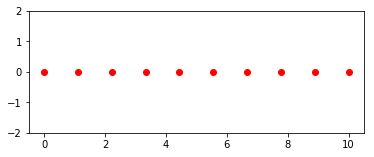

In [103]:
ax = plt.gca()

def draw_frame(frame):
    l1 = frame.Pwf
    l2 = frame.Pwf + frame.tr*0.5
    line = mlines.Line2D([l1[0], l2[0]], [l1[1], l2[1]], color='red')
    ax.add_line(line)
    l1 = frame.Pwf
    l2 = frame.Pwf + frame.nr*0.5
    line = mlines.Line2D([l1[0], l2[0]], [l1[1], l2[1]], color='green')
    ax.add_line(line)
    
path = np.array([[x, 0, 0] for x in np.linspace(0, 10, 10)])
car_p = np.array([0, 1, 0])
car_v = np.array([1, 0, 0])
ROAD_WIDTH = 4

#plt.xlim(-1, 7)
plt.ylim(-2, 2)
ax.set_aspect('equal')
plt.plot(path[:,0], path[:,1], 'ro')
plt.show()    

frenet = FrenetFrame(path[0], path[1])    
car_p_f = frenet.point_to(car_p)  # Car positon in Frenet Frame
car_v_f = frenet.vector_to(car_v) # Car velocity in Frenet Frame




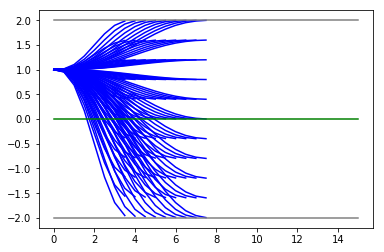

In [138]:
def combine(variant):
    ts, longitudinal_coefs, lateral_coefs = variants
    

T_MIN = 4.0
T_MAX = 8.0
T_STEP = 0.5

D_MIN = -ROAD_WIDTH/2
D_MAX = ROAD_WIDTH/2
D_STEP = 0.4

VELOCITY = 1
T_ALL = 15

quintics = []

# Create a set of lateral and longitudal quintic polynoms
for ti in np.arange(T_MIN, T_MAX + T_STEP, T_STEP):
    ts = np.arange(0, ti, T_STEP) #??
    
    for di in np.arange(D_MIN, D_MAX + DI_STEP, D_STEP):
        # Create lateral motion
        d1 = car_p_f[1]    # lateral position
        dd1 = car_v_f[1]   # lateral speed 
        lateral_coefs = quintic_solve([d1, dd1, 0], [di, 0, 0], ti)
            
        # Create longitude motion
        # For now assume constant velocity
        s1 = car_p_f[0]   # longitudinal position
        ds1 = car_v_f[0]  # longitudinal speed
        longitudinal_coefs = [0, 0, 0, 0, VELOCITY, 0]
        quintics.append((ts, longitudinal_coefs, lateral_coefs))    

        
plt.plot([0, T_ALL], [D_MAX, D_MAX], color='grey')
plt.plot([0, T_ALL], [0, 0], color='green')
plt.plot([0, T_ALL], [D_MIN, D_MIN], color='grey')
plt.show()

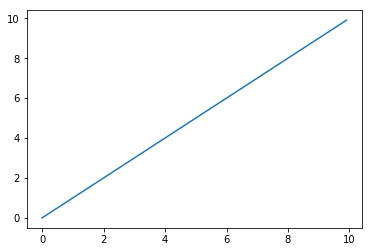

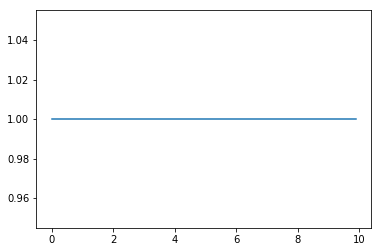

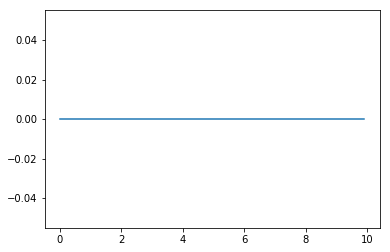

In [141]:
coefs = [0, 0, 0, 0, 1, 0]
ts = np.arange(0, 10, 0.1)
x, dx, ddx = quintic_interpolate(coefs, ts)
plt.plot(ts, x)
plt.show()
plt.plot(ts, dx)
plt.show()
plt.plot(ts, ddx)
plt.show()